# Introduction

This is first part of https://www.kaggle.com/mustafacicek/detailed-marketing-cohort-pareto-rfm-forecast

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from matplotlib.ticker import PercentFormatter
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from itertools import combinations

pd.options.mode.chained_assignment = None

plt.rcParams["axes.facecolor"] = "#A2A2A2"
plt.rcParams["axes.grid"] = 1

<a id="section-one"></a>

# 1) General Infos & Playing with Features

In [2]:
df = pd.read_csv("../input/ecommerce-data/data.csv")
display(df.head())
print(df.shape)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


(541909, 8)


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


We have missing values for column Description and CustomerID. Go deeper

In [4]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [5]:
df[df.Description.isnull()]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,12/1/2010 11:52,0.0,NaN,United Kingdom
1970,536545,21134,NaN,1,12/1/2010 14:32,0.0,NaN,United Kingdom
1971,536546,22145,NaN,1,12/1/2010 14:33,0.0,NaN,United Kingdom
1972,536547,37509,NaN,1,12/1/2010 14:33,0.0,NaN,United Kingdom
1987,536549,85226A,NaN,1,12/1/2010 14:34,0.0,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
535322,581199,84581,NaN,-2,12/7/2011 18:26,0.0,NaN,United Kingdom
535326,581203,23406,NaN,15,12/7/2011 18:31,0.0,NaN,United Kingdom
535332,581209,21620,NaN,6,12/7/2011 18:35,0.0,NaN,United Kingdom
536981,581234,72817,NaN,27,12/8/2011 10:33,0.0,NaN,United Kingdom


When description is null, we have 0 unit price and missing customer ids. Let's check for whole data.

In [6]:
df[df.Description.isnull()].CustomerID.nunique()

0

In [7]:
df[df.Description.isnull()].UnitPrice.value_counts()

0.0    1454
Name: UnitPrice, dtype: int64

When description is null, we have no available customer id and zero unit price for all data. Let's drop nan values.

In [8]:
df = df[df.Description.notnull()]

In [9]:
df[df.CustomerID.isnull()]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,12/1/2010 14:32,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,12/1/2010 14:32,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,12/1/2010 14:32,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,12/1/2010 14:32,1.66,NaN,United Kingdom
1447,536544,21790,VINTAGE SNAP CARDS,9,12/1/2010 14:32,1.66,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
541536,581498,85099B,JUMBO BAG RED RETROSPOT,5,12/9/2011 10:26,4.13,NaN,United Kingdom
541537,581498,85099C,JUMBO BAG BAROQUE BLACK WHITE,4,12/9/2011 10:26,4.13,NaN,United Kingdom
541538,581498,85150,LADIES & GENTLEMEN METAL SIGN,1,12/9/2011 10:26,4.96,NaN,United Kingdom
541539,581498,85174,S/4 CACTI CANDLES,1,12/9/2011 10:26,10.79,NaN,United Kingdom


At first look, we can see records that have missing customer id, there is no specific characteristics.

StockCode contains non-numeric records i.e. DOT. It is a cue for examining stock codes.

In [10]:
print("We have {} observations.".format(df.shape[0]))

df = df[df.CustomerID.notnull()]

print("We have {} observations after removing unknown customers.".format(df.shape[0]))

We have 540455 observations.
We have 406829 observations after removing unknown customers.


In [11]:
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

We are done with systematically missing values. But lets go deeper.

Sometimes, missing values are filled with some denotations. "NAN", "na", "?", "Unknown", and so on. Let's check them.

In [12]:
df[df.Description.str.len() < 5]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


In [13]:
df.InvoiceNo.value_counts()

576339     542
579196     533
580727     529
578270     442
573576     435
          ... 
564811       1
565591       1
541505       1
C546645      1
578674       1
Name: InvoiceNo, Length: 22190, dtype: int64

InvoiceNo has coded with 6 digit numeric characters. We can see that some InvoiceNo records starts with the letter C. This means cancellation.

In [14]:
df[df["InvoiceNo"].str.startswith("C")]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,12/1/2010 9:41,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/1/2010 9:49,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,12/1/2010 10:24,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,12/9/2011 9:57,0.83,14397.0,United Kingdom
541541,C581499,M,Manual,-1,12/9/2011 10:28,224.69,15498.0,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,12/9/2011 11:57,10.95,15311.0,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,12/9/2011 11:58,1.25,17315.0,United Kingdom


Cancelled invoices have negative quantity.

In [15]:
df["Cancelled"] = df["InvoiceNo"].apply(lambda x: 1 if x.startswith("C") else 0)

Can we have both cancellation record, and record before cancellation. I mean, for example, we have C536379, have we 536379 ?

In [16]:
cancelled_invoiceNo = df[df.Cancelled == 1].InvoiceNo.tolist()
cancelled_invoiceNo = [x[1:] for x in cancelled_invoiceNo]

cancelled_invoiceNo[:5]

['536379', '536383', '536391', '536391', '536391']

In [17]:
df[df["InvoiceNo"].isin(cancelled_invoiceNo)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancelled


Nothing, we have just cancellation.

Well, maybe we have different pattern about InvoiceNo. Let's check it

In [18]:
df[df.InvoiceNo.str.len() != 6]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancelled
141,C536379,D,Discount,-1,12/1/2010 9:41,27.50,14527.0,United Kingdom,1
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/1/2010 9:49,4.65,15311.0,United Kingdom,1
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,12/1/2010 10:24,1.65,17548.0,United Kingdom,1
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom,1
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom,1
...,...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,12/9/2011 9:57,0.83,14397.0,United Kingdom,1
541541,C581499,M,Manual,-1,12/9/2011 10:28,224.69,15498.0,United Kingdom,1
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,12/9/2011 11:57,10.95,15311.0,United Kingdom,1
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,12/9/2011 11:58,1.25,17315.0,United Kingdom,1


No, we only have proper invoices and cancellations for InvoiceNo. We don't have any different pattern.

In [19]:
df = df[df.Cancelled == 0]

Stock Codes generally contains 5 digit numerical codes.

In [20]:
df[df.StockCode.str.contains("^[a-zA-Z]")].StockCode.value_counts()

POST            1099
M                290
C2               133
DOT               16
BANK CHARGES      12
PADS               4
Name: StockCode, dtype: int64

In [21]:
df[df.StockCode.str.contains("^[a-zA-Z]")].Description.value_counts()

POSTAGE                       1099
Manual                         290
CARRIAGE                       133
DOTCOM POSTAGE                  16
Bank Charges                    12
PADS TO MATCH ALL CUSHIONS       4
Name: Description, dtype: int64

It looks like data contains more than customer transactions. I will drop them.

In [22]:
df[df.StockCode.str.len() > 5].StockCode.value_counts()

85123A    2035
85099B    1618
82494L     820
85099F     664
85099C     659
          ... 
35597B       1
35610B       1
90187B       1
90141E       1
17028J       1
Name: StockCode, Length: 875, dtype: int64

In [23]:
df[df.StockCode.str.len() > 5].Description.value_counts()

WHITE HANGING HEART T-LIGHT HOLDER    2028
JUMBO BAG RED RETROSPOT               1618
WOODEN FRAME ANTIQUE WHITE             820
JUMBO BAG STRAWBERRY                   664
JUMBO  BAG BAROQUE BLACK WHITE         659
                                      ... 
ACRYLIC JEWEL SNOWFLAKE,PINK             1
5 STRAND GLASS NECKLACE AMETHYST         1
PINK ROUND COMPACT MIRROR                1
BLUE LEAVES AND BEADS PHONE CHARM        1
LETTER "Z" BLING KEY RING                1
Name: Description, Length: 887, dtype: int64

Some stock codes have a letter at the end of their codes. I don't know what they refers, so I will keep them.

In [24]:
df =  df[~ df.StockCode.str.contains("^[a-zA-Z]")]

In [25]:
df["Description"] = df["Description"].str.lower()

I just standardize descriptions with converting them to all lowercase characters.

Stock Codes - Description

In [26]:
df.groupby("StockCode")["Description"].nunique()[df.groupby("StockCode")["Description"].nunique() != 1]

StockCode
16156L    2
17107D    3
20622     2
20725     2
20914     2
         ..
85184C    2
85185B    2
90014A    2
90014B    2
90014C    2
Name: Description, Length: 213, dtype: int64

213 Stock codes have more than one description. Let's check some of them.

In [27]:
df[df.StockCode == "16156L"].Description.value_counts()

wrap carousel     14
wrap, carousel     4
Name: Description, dtype: int64

In [28]:
df[df.StockCode == "17107D"].Description.value_counts()

flower fairy,5 summer b'draw liners    25
flower fairy 5 drawer liners           21
flower fairy 5 summer draw liners       1
Name: Description, dtype: int64

In [29]:
df[df.StockCode == "90014C"].Description.value_counts()

silver/black orbit necklace        2
silver and black orbit necklace    1
Name: Description, dtype: int64

Seems we have just a litle differences between them, i.e. "," or "/"

In [30]:
df.CustomerID.value_counts()

17841.0    7838
14911.0    5591
14096.0    5095
12748.0    4580
14606.0    2697
           ... 
15562.0       1
17956.0       1
16454.0       1
13391.0       1
17443.0       1
Name: CustomerID, Length: 4335, dtype: int64

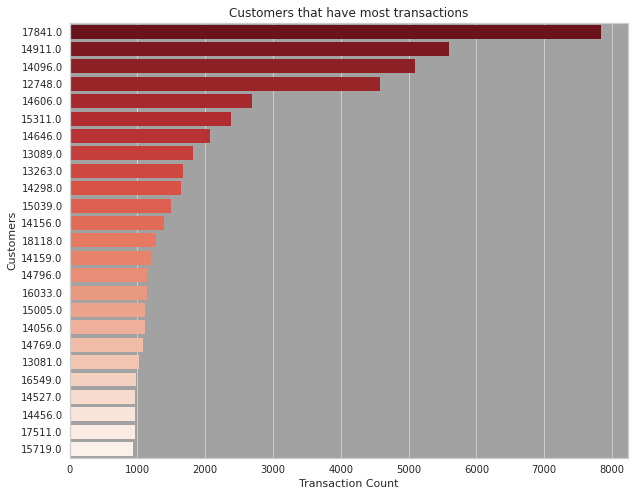

In [31]:
customer_counts = df.CustomerID.value_counts().sort_values(ascending=False).head(25)

fig, ax = plt.subplots(figsize = (10, 8))

sns.barplot(y = customer_counts.index, x = customer_counts.values, orient = "h", 
            ax = ax, order = customer_counts.index, palette = "Reds_r")

plt.title("Customers that have most transactions")
plt.ylabel("Customers")
plt.xlabel("Transaction Count")

plt.show()

In [32]:
df.Country.value_counts()

United Kingdom          354005
Germany                   8659
France                    8034
EIRE                      7138
Spain                     2423
Netherlands               2326
Belgium                   1935
Switzerland               1811
Portugal                  1425
Australia                 1184
Norway                    1049
Channel Islands            744
Italy                      741
Finland                    647
Cyprus                     612
Sweden                     428
Austria                    384
Denmark                    367
Poland                     325
Japan                      321
Israel                     248
Unspecified                244
Singapore                  215
Iceland                    182
USA                        179
Canada                     150
Greece                     142
Malta                      109
United Arab Emirates        67
RSA                         57
European Community          57
Lebanon                     45
Lithuani

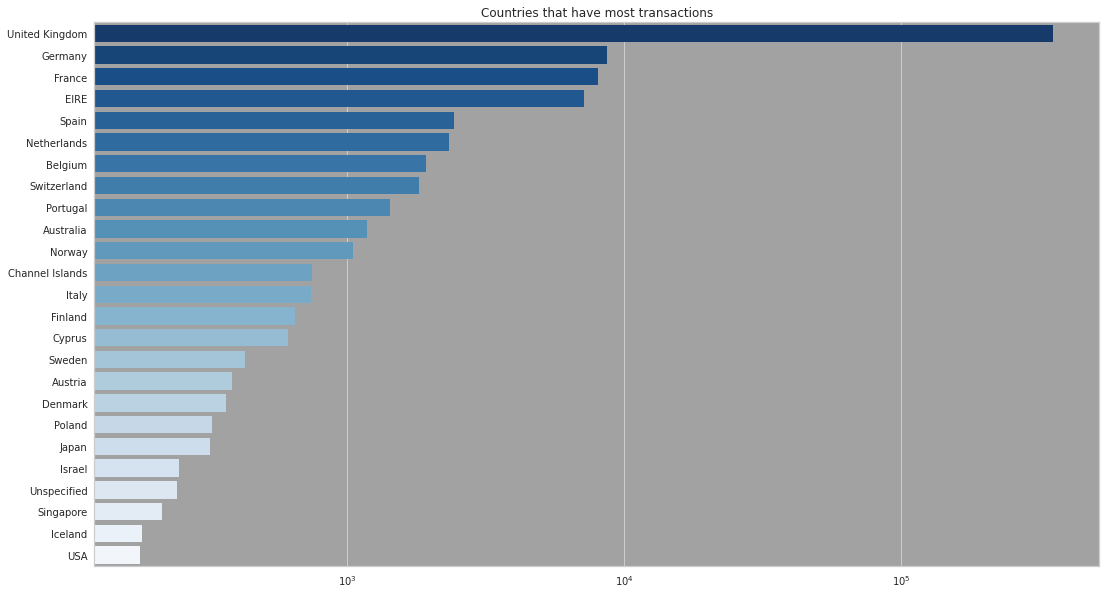

In [33]:
country_counts = df.Country.value_counts().sort_values(ascending=False).head(25)

fig, ax = plt.subplots(figsize = (18, 10))

sns.barplot(x = country_counts.values, y = country_counts.index, orient = "h", 
            ax = ax, order = country_counts.index, palette = "Blues_r")
plt.title("Countries that have most transactions")
plt.xscale("log")
plt.show()

In [34]:
df["UnitPrice"].describe()

count    396370.000000
mean          2.867983
std           4.264566
min           0.000000
25%           1.250000
50%           1.950000
75%           3.750000
max         649.500000
Name: UnitPrice, dtype: float64

0 unit price?

In [35]:
df[df.UnitPrice == 0].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancelled
9302,537197,22841,round cake tin vintage green,1,12/5/2010 14:02,0.0,12647.0,Germany,0
33576,539263,22580,advent calendar gingham sack,4,12/16/2010 14:36,0.0,16560.0,United Kingdom,0
40089,539722,22423,regency cakestand 3 tier,10,12/21/2010 13:45,0.0,14911.0,EIRE,0
47068,540372,22090,paper bunting retrospot,24,1/6/2011 16:41,0.0,13081.0,United Kingdom,0
47070,540372,22553,plasters in tin skulls,24,1/6/2011 16:41,0.0,13081.0,United Kingdom,0


I didn't find any pattern. So, I remove them.

In [36]:
print("We have {} observations.".format(df.shape[0]))

df = df[df.UnitPrice > 0]

print("We have {} observations after removing records that have 0 unit price.".format(df.shape[0]))

We have 396370 observations.
We have 396337 observations after removing records that have 0 unit price.


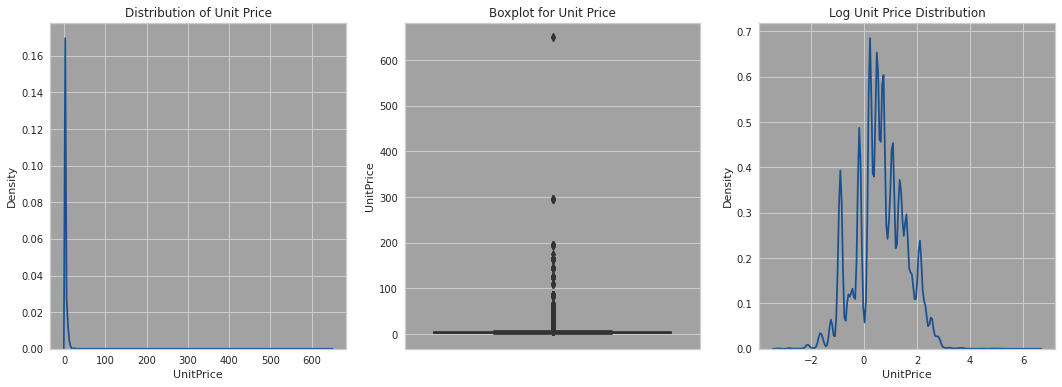

In [37]:
fig, axes = plt.subplots(1, 3, figsize = (18, 6))

sns.kdeplot(df["UnitPrice"], ax = axes[0], color = "#195190").set_title("Distribution of Unit Price")
sns.boxplot(y = df["UnitPrice"], ax = axes[1], color = "#195190").set_title("Boxplot for Unit Price")
sns.kdeplot(np.log(df["UnitPrice"]), ax = axes[2], color = "#195190").set_title("Log Unit Price Distribution")

plt.show()

In [38]:
print("Lower limit for UnitPrice: " + str(np.exp(-2)))
print("Upper limit for UnitPrice: " + str(np.exp(3)))

Lower limit for UnitPrice: 0.1353352832366127
Upper limit for UnitPrice: 20.085536923187668


In [39]:
np.quantile(df.UnitPrice, 0.99)

12.75

In [40]:
print("We have {} observations.".format(df.shape[0]))

df = df[(df.UnitPrice > 0.1) & (df.UnitPrice < 20)]

print("We have {} observations after removing unit prices smaller than 0.1 and greater than 20.".format(df.shape[0]))

We have 396337 observations.
We have 395385 observations after removing unit prices smaller than 0.1 and greater than 20.


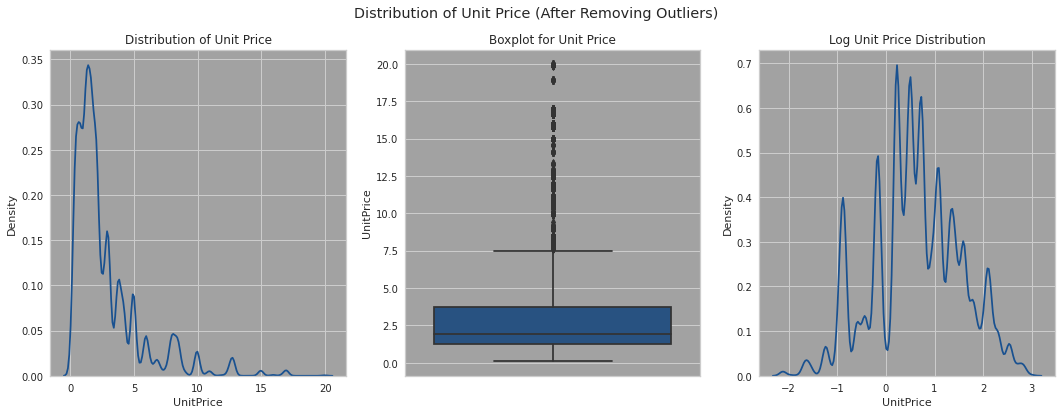

In [41]:
fig, axes = plt.subplots(1, 3, figsize = (18, 6))

sns.kdeplot(df["UnitPrice"], ax = axes[0], color = "#195190").set_title("Distribution of Unit Price")
sns.boxplot(y = df["UnitPrice"], ax = axes[1], color = "#195190").set_title("Boxplot for Unit Price")
sns.kdeplot(np.log(df["UnitPrice"]), ax = axes[2], color = "#195190").set_title("Log Unit Price Distribution")

fig.suptitle("Distribution of Unit Price (After Removing Outliers)")
plt.show()

In [42]:
df["Quantity"].describe()

count    395385.000000
mean         12.946075
std         179.665683
min           1.000000
25%           2.000000
50%           6.000000
75%          12.000000
max       80995.000000
Name: Quantity, dtype: float64

75%          12.000000

max       80995.000000

Let's look at these outliers.

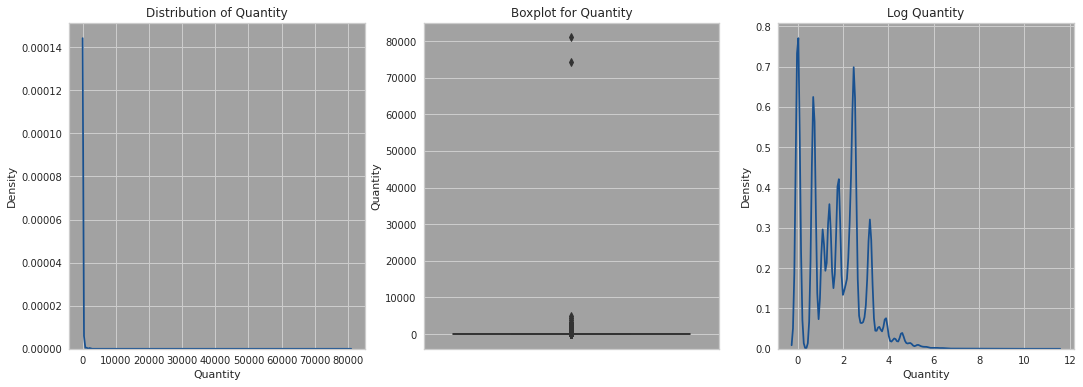

In [43]:
fig, axes = plt.subplots(1, 3, figsize = (18, 6))

sns.kdeplot(df["Quantity"], ax = axes[0], color = "#195190").set_title("Distribution of Quantity")
sns.boxplot(y = df["Quantity"], ax = axes[1], color = "#195190").set_title("Boxplot for Quantity")
sns.kdeplot(np.log(df["Quantity"]), ax = axes[2], color = "#195190").set_title("Log Quantity")
plt.show()

In [44]:
print("Upper limit for Quantity: " + str(np.exp(5)))

Upper limit for Quantity: 148.4131591025766


In [45]:
np.quantile(df.Quantity, 0.99)

120.0

In [46]:
print("We have {} observations.".format(df.shape[0]))

df = df[(df.Quantity < 150)]

print("We have {} observations after removing quantities greater than 150.".format(df.shape[0]))

We have 395385 observations.
We have 392735 observations after removing quantities greater than 150.


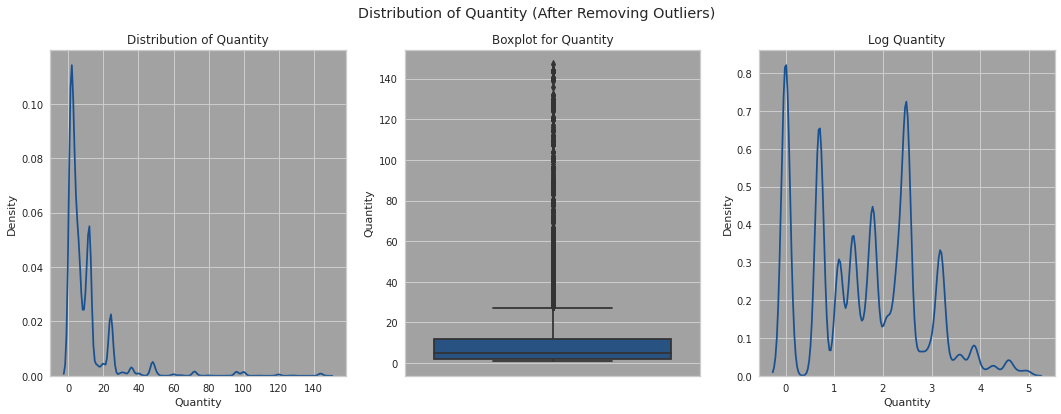

In [47]:
fig, axes = plt.subplots(1, 3, figsize = (18, 6))

sns.kdeplot(df["Quantity"], ax = axes[0], color = "#195190").set_title("Distribution of Quantity")
sns.boxplot(y = df["Quantity"], ax = axes[1], color = "#195190").set_title("Boxplot for Quantity")
sns.kdeplot(np.log(df["Quantity"]), ax = axes[2], color = "#195190").set_title("Log Quantity")

fig.suptitle("Distribution of Quantity (After Removing Outliers)")
plt.show()

In [48]:
df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [49]:
df.drop("Cancelled", axis = 1, inplace = True)
df.to_csv("online_retail_final.csv", index = False)

# Next

You can reach this data from here. https://www.kaggle.com/mustafacicek/online-retail-final

Next chapters:

https://www.kaggle.com/mustafacicek/marketing-analytics-cohort-analysis

https://www.kaggle.com/mustafacicek/marketing-analytics-pareto-principle

https://www.kaggle.com/mustafacicek/marketing-analytics-rfm-analysis

https://www.kaggle.com/mustafacicek/marketing-analytics-forecasting

Full work: https://www.kaggle.com/mustafacicek/detailed-marketing-cohort-pareto-rfm-forecast